In [1]:
using SchwarzChristoffel

INFO: Recompiling stale cache file /Users/jeff/.julia/lib/v0.6/SchwarzChristoffel.ji for module SchwarzChristoffel.


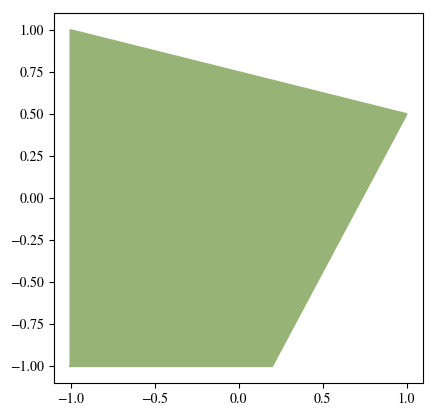

In [4]:
p = Polygon([-1.0,0.2,1.0,-1.0],[-1.0,-1.0,0.5,1.0])
plot(p)

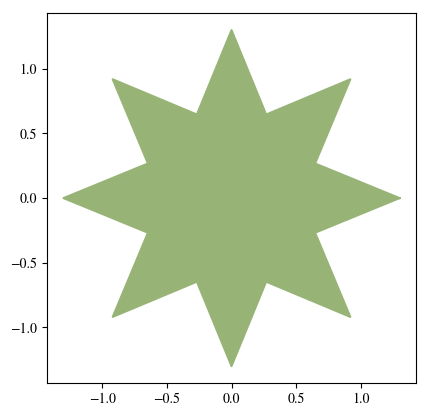

In [6]:
n = 8; dθ = 2π/(2n)
θ = collect(0:dθ:2π-dθ)
w = (1+0.3cos.(n*θ)).*exp.(im*θ)
p = Polygon(w)
plot(p)

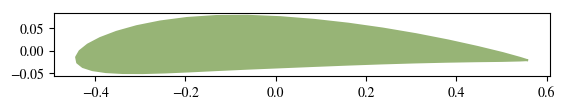

In [2]:
w = naca4(0.04,0.4,0.12;len=1)
p = Polygon(w)
plot(p)

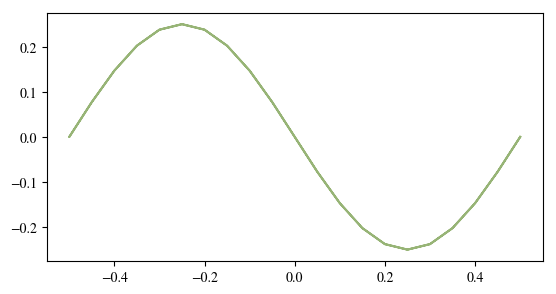

In [6]:
ht = 0.25
nwave = 2
nseg = 20
x = 1.0
len = 1.0
dx = len/nseg
vert = Complex128[]
for j = 1:nseg+1
    push!(vert,x+im*ht*sin(π*nwave*x))
    x -= dx
end
vert = [vert;flipdim(vert[2:end-1],1)]
vert -=mean(vert)
p = Polygon(vert);
plot(p)

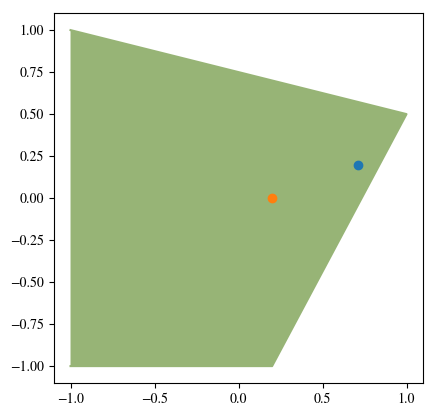

1×2 BitArray{2}:
 true  true

In [6]:
z = [0.71+im*0.2 0.2+im*0]
plot(p)
PyPlot.plot(real.(z),imag.(z),marker="o")
isinpoly.(z,p,1e-5)

In [9]:
m = ExteriorMap(p)

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     1.223210e+01              NaN
     1     1.134173e+01     3.632498e-02
     2     9.661939e+00     7.418173e-02
     3     6.752205e+00     1.566856e-01
     4     2.813983e+00     3.533744e-01
     5     1.184346e+00     5.209001e-01
     6     1.108480e+00     7.562127e-01
     7     9.762690e-01     1.655858e+00
     8     2.640452e-01     1.288004e+00
     9     1.095028e+02     2.355139e-16
    10     1.095028e+02     0.000000e+00
    11     8.061735e+00     5.551115e-17
    12     7.062979e-01     0.000000e+00
    13     1.462659e-01     8.674025e-01
    14     8.003674e-02     2.347121e-01
    15     4.546233e-03     2.693872e-01
    16     1.365595e-04     3.703288e-02
    17     3.554069e-06     4.897533e-03
    18     1.371901e-10     3.291704e-05
  3.560942 seconds (7.40 M allocations: 3.164 GiB, 17.46% gc time)


Exterior map with
   vertices: (0.45,-0.0773), (0.5,-0.0), (0.45,-0.0773), (0.4,-0.1469), (0.35,-0.2023), (0.3,-0.2378), (0.25,-0.25), (0.2,-0.2378), (0.15,-0.2023), (0.1,-0.1469), (0.05,-0.0773), (-0.0,0.0), (-0.05,0.0773), (-0.1,0.1469), (-0.15,0.2023), (-0.2,0.2378), (-0.25,0.25), (-0.3,0.2378), (-0.35,0.2023), (-0.4,0.1469), (-0.45,0.0773), (-0.5,-0.0), (-0.45,0.0773), (-0.4,0.1469), (-0.35,0.2023), (-0.3,0.2378), (-0.25,0.25), (-0.2,0.2378), (-0.15,0.2023), (-0.1,0.1469), (-0.05,0.0773), (-0.0,0.0), (0.05,-0.0773), (0.1,-0.1469), (0.15,-0.2023), (0.2,-0.2378), (0.25,-0.25), (0.3,-0.2378), (0.35,-0.2023), (0.4,-0.1469), 
   interior angles/π: 0.9847, 0.0, 1.0153, 1.0359, 1.0695, 1.1202, 1.1528, 1.1202, 1.0695, 1.0359, 1.0153, 1.0, 0.9847, 0.9641, 0.9305, 0.8798, 0.8472, 0.8798, 0.9305, 0.9641, 0.9847, 0.0, 1.0153, 1.0359, 1.0695, 1.1202, 1.1528, 1.1202, 1.0695, 1.0359, 1.0153, 1.0, 0.9847, 0.9641, 0.9305, 0.8798, 0.8472, 0.8798, 0.9305, 0.9641, 
   prevertices on circle: (1.0,0.0),

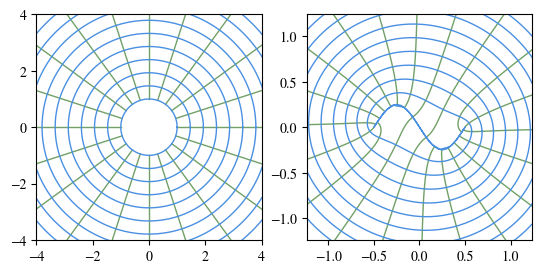

In [8]:
conformal_grid(m)

In [3]:
using NLsolve

In [4]:
struct DabsQuad{T,N,NQ}
  beta :: Vector{T}
  qdat :: Tuple{Array{T,2},Array{T,2}}
end

function DabsQuad(beta::Vector{T},tol::T) where T
  n = length(beta)
  nqpts = max(ceil(Int,-log10(tol)),2)
  qdat = qdata(beta,nqpts)
  DabsQuad{T,n,nqpts}(beta,qdat)
end

function DabsQuad(beta::Vector{T},
                  qdat::Tuple{Array{T,2},Array{T,2}}) where T
  n = length(beta)
  nqpts = size(qdat[1],1)
  DabsQuad{T,n,nqpts}(beta,qdat)
end

function (I::DabsQuad{T,N,NQ})(zeta1::Vector{Complex128},zeta2::Vector{Complex128},sing1::Vector{Int64},zeta::Vector{Complex128}) where {T,N,NQ}

   (qnode,qwght) = I.qdat
   argz = angle.(zeta)

   argz1 = angle.(zeta1)
   argz2 = angle.(zeta2)
   ang21 = angle.(zeta2./zeta1)
    
   bigargz = transpose(argz[:,ones(Int,NQ)]) 

   discont = (argz2-argz1).*ang21 .< 0
   argz2[discont] += 2π*sign.(ang21[discont])
   
   if isempty(sing1)
     sing1 = zeros(size(zeta1))
   end
   result = zeros(Float64,size(zeta1))
   
   nontriv = find(zeta1.!=zeta2)
    #tic()
   for k in nontriv
     z1k, z2k, arg1k, arg2k, sing1k = zeta1[k], zeta2[k], argz1[k], argz2[k], sing1[k] 
     zetas = vcat(zeta[1:sing1k-1],zeta[sing1k+1:end])
     dist = min(1,2*minimum(abs.(zetas-z1k))/abs(z2k-z1k))
     argr = arg1k + dist*(arg2k-arg1k)
     ind = ((sing1k+N) % (N+1)) + 1
     nd = 0.5*((argr-arg1k)*qnode[:,ind] + argr + arg1k)
     wt = 0.5*abs(argr-arg1k)*qwght[:,ind]
     #θ = hcat([(nd - argz[i] + 2π).%(2π) for i = 1:N]...)
     θ = (nd[:,ones(Int,N)]-bigargz.+2π).%(2π)
     θ[θ.>π] = 2π-θ[θ.>π]
     terms = 2sin.(0.5θ)
     if !any(terms==0.0)
        if sing1k > 0
            terms[:,sing1k] ./= abs.(nd-arg1k)
            wt .*= (0.5*abs.(argr-arg1k)).^I.beta[sing1k]
        end
        result[k] = At_mul_B(exp.(log.(terms)*I.beta),wt)    
        while dist < 1.0
            argl = argr
            zetal = exp(im*argl)
            dist = min(1,2*minimum(abs.(zeta-zetal)/abs(zetal-zeta2k)))
            argr = argl + dist*(arg2k-argl)
            nd = 0.5*((argr-argl)*qnode[:,n+1] + argr + argl)
            wt = 0.5*abs(argr-argl)*qwght[:,n+1]
            #θ = hcat([(nd - argz[i] + 2π).%(2π) for i = 1:N]...)
            θ = (nd[:,ones(Int,N)]-bigargz.+2π).%(2π)
            θ[θ.>π] = 2π-θ[θ.>π]
            terms = 2sin.(0.5θ)
            result[k] += At_mul_B(exp.(log.(terms)*I.beta))*wt
        end
     end
   end
    #toc()
    #nothing
   return result
end

In [5]:
struct Depfun{T,N,NQ}
    zeta :: Vector{Complex{T}}
    beta :: Vector{T}
    nmlen :: Vector{T}
    qdat :: Tuple{Array{T,2},Array{T,2}}
    θ    :: Vector{T}
    mid  :: Vector{Complex{T}}
    ints :: Vector{T}
    dabsquad :: DabsQuad{T,N,NQ}
end

In [6]:
function Depfun(beta::Vector{T},nmlen::Vector{T},qdat:: Tuple{Array{T,2},Array{T,2}}) where T
    # should compute nmlen in here
    n = length(beta)
    nq = size(qdat[1],1)
    zeta = zeros(Complex128,n)
    θ = zeros(n-1)
    mid = zeros(Complex128,n-2)
    ints = zeros(Complex128,n-2)
    dabsquad = DabsQuad(beta,qdat)
    Depfun{T,n,nq}(zeta,beta,nmlen,qdat,θ,mid,ints,dabsquad)
end

Depfun

In [7]:
function (R::Depfun{T,N,NQ})(F,y) where {T,N,NQ}
  
  
  y_to_zeta!(R.zeta,R.θ,y)
    
  @. R.mid = exp(im*0.5*(R.θ[1:N-2]+R.θ[2:N-1]))

  #dabsquad(z1,z2,sing1) = dabsquad(z1,z2,sing1,zeta,beta,qdat)

  tic()  
  #broadcast!((x1,y1,z1,x2,y2,z2) -> dabsquad(x1,y1,z1,R.zeta)+dabsquad(x2,y2,z2,R.zeta),R.ints,
  #                          R.zeta[1:N-2],R.mid,collect(1:N-2),
  #                          R.zeta[2:N-1],R.mid,collect(2:N-1))
  R.ints .= R.dabsquad(R.zeta[1:N-2],R.mid,collect(1:N-2),R.zeta) 
  R.ints .+= R.dabsquad(R.zeta[2:N-1],R.mid,collect(2:N-1),R.zeta)

  toc()  
  
  #ints .= dabsquad.(zeta[1:n-2],mid,collect(1:n-2))+
  #         dabsquad.(zeta[2:n-1],mid,collect(2:n-1))

  if N > 3
    @. F[1:N-3] = abs(R.ints[2:N-2])/abs(R.ints[1]) - R.nmlen
  end

  res = -sum(R.beta./R.zeta)/R.ints[1]
  @. F[N-2] = real(res)
  @. F[N-1] = imag(res)
end

In [9]:
function y_to_zeta!(zeta::Vector{Complex{T}},θ::Vector{T},y::Vector{T}) where T

  cs = cumsum(cumprod([1;exp.(-y)]))
  n = length(cs)
  @. θ = 2π*cs[1:n-1]/cs[n]
  zeta[n] = 1.0
  @. zeta[1:n-1] = exp(im*θ)

end

y_to_zeta! (generic function with 1 method)

In [19]:
tol = 1e-8
n = length(p.vert)


  zeta0 = Complex128[]

  w = flipdim(vertex(p),1)
  beta = 1.-flipdim(interiorangle(p),1)
nqpts = max(ceil(Int,-log10(tol)),2)
  qdat = SchwarzChristoffel.Integration.qdata(beta,nqpts)
  
    len = abs.(diff(circshift(w,1)))
    nmlen = abs.(len[3:n-1]/len[2])
    y0 = zeros(n-1)

    #dabsquad = DabsQuad(beta,qdat);
    depfun! = Depfun(beta,nmlen,qdat);


    F0 = similar(y0)
    depfun!(F0,y0)
    println(norm(F0))
    #df = OnceDifferentiable(depfun!, y0, F0)
    #@time sol = nlsolve(df,y0)

    #zeta = zeros(Complex128,n)
    #θ = zeros(n-1)
    #y_to_zeta!(zeta,θ,sol.zero)


elapsed time: 0.002676862 seconds
7.208050006967503


In [196]:
any(isnan.(df.DF))

false

In [26]:
fieldnames(sol)

12-element Array{Symbol,1}:
 :method       
 :initial_x    
 :zero         
 :residual_norm
 :iterations   
 :x_converged  
 :xtol         
 :f_converged  
 :ftol         
 :trace        
 :f_calls      
 :g_calls      

In [30]:
sol.method

"Trust-region with dogleg and autoscaling"

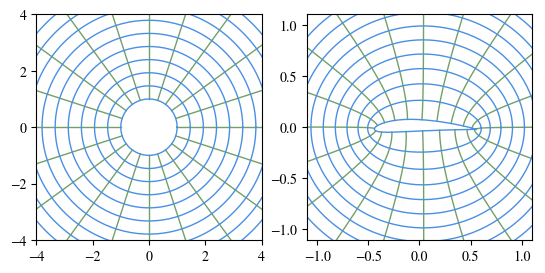

In [5]:
conformal_grid(m)

In [11]:
m = ExteriorMap(p;tol=1e-12)

Exterior map with
   vertices: (-1.0,-1.0), (0.2,-1.0), (1.0,0.5), (-1.0,1.0), 
   interior angles/π: 0.5, 0.656, 0.422, 0.422, 
   prevertices on circle: (1.0,0.0), (0.3764,-0.9265), (-0.9024,-0.4309), (-0.1868,0.9824), 
   constant = 0.6722 + 0.7669im, accuracy = 1.0e-12, 
   number of multipole coefficients = 12


In [9]:
prev, C = parameters(m)

(Complex{Float64}[1.0+0.0im, 0.376406-0.926455im, -0.902383-0.430935im, -0.186756+0.982406im], 0.6722109863402015 + 0.7668866078562682im)

In [42]:
area(m)/ccoeff[1]

2.3639234904370356 - 0.0im

In [45]:
ccoeff, dcoeff = coefficients(m);

In [46]:
ccoeff

14-element Array{Complex{Float64},1}:
      1.12786+0.0im        
 -1.42493e-16+4.60899e-17im
 -3.13044e-17-3.13044e-16im
  6.26088e-17-3.86088e-16im
  3.30026e-16-3.13044e-17im
   5.0087e-17+1.37739e-16im
 -3.96522e-17-3.13044e-17im
  9.98759e-17-5.96274e-18im
     0.202134+1.75453e-14im
 -7.43133e-18-1.09806e-17im
  1.41027e-17+8.39839e-17im
 -6.77881e-17+1.23623e-16im
 -1.93438e-16+7.8648e-18im 
 -3.88048e-17-9.57267e-17im

In [5]:
zeta = [0.1,0.5-0.75im,-0.25-0.3im]
dz, ddz = evalderiv(zeta,m,true);
dz

3-element Array{Complex{Float64},1}:
  67.2068+76.6284im 
 -1.11666+0.544576im
  3.99129-5.30641im 

In [6]:
zeta = [1.0+3.0im,-2.0-2.0im,0.0+1.1im]
z = evaluate(zeta,m)

3-element Array{Complex{Float64},1}:
   0.81614+3.02956im 
  -2.25237-2.08523im 
 -0.333104+0.975837im

In [16]:
zeta = collect(1.1:0.1:2.0) + 0.1im
dz,ddz = evalderiv(zeta,m)
dz

10-element Array{Complex{Float64},1}:
 0.872356-0.394475im 
 0.901724-0.289355im 
 0.925562-0.217994im 
 0.944059-0.168264im 
 0.958255-0.132657im 
  0.96919-0.106522im 
 0.977695-0.0869128im
 0.984389-0.0719115im
 0.989723-0.0602376im
 0.994025-0.0510144im

In [11]:
z = evaluate(zeta,m)

3-element Array{Complex{Float64},1}:
   0.81614+3.02956im 
  -2.25237-2.08523im 
 -0.333104+0.975837im

In [7]:
mean([sum(ccoeff.*zeta[i].^(1:-1:-m.ncoeff))-z[i] for i = 1:length(zeta)])

2.5518320641274943e-5 + 8.985895672545634e-5im

In [64]:
m = 0.0; p = 0.0; t = 0.12;
np = 20
npan = 2*np-2
an = 1.5
anp = an+1
x = zeros(np)

θ = zeros(size(x))
yc = zeros(size(x))

for j = 1:np
    frac = Float64((j-1)/(np-1))
    x[j] = 1 - anp*frac*(1-frac)^an-(1-frac)^anp;
    if x[j] < p
        yc[j] = m/p^2*(2*p*x[j]-x[j]^2)
        if p > 0
            θ[j] = atan(2*m/p*(1-x[j]/p))
        end
    else
        yc[j] = m/(1-p)^2*((1-2*p)+2*p*x[j]-x[j]^2)
        if p > 0
            th[j] = atan(2*m*p/(1-p)^2*(1-x[j]/p))
        end
    end
end

xu = zeros(size(x))
yu = xu
xl = xu
yl = yu

yt = t/0.20*(0.29690*sqrt.(x)-0.12600*x-0.35160*x.^2+0.28430*x.^3-0.10150*x.^4)

xu = x-yt.*sin.(θ)
yu = yc+yt.*cos.(θ)

xl = x+yt.*sin.(θ)
yl = yc-yt.*cos.(θ)

rt = 1.1019*t^2;
θ0 = 0
if p > 0
    θ0 = atan(2*m/p)
end
# Center of leading edge radius
xrc = rt*cos(θ0) 
yrc = rt*sin(θ0)
θle = collect(0:π/50:2π)
xlec = xrc+rt*cos.(θle)
ylec = yrc+rt*sin.(θle)

# Assemble data
coords = [xu yu xl yl x yc]
cole = [xlec ylec]

# Close the trailing edge
xpanold = [0.5*(xl[np]+xu[np]); flipdim(xl[2:np-1],1); xu[1:np-1]]
ypanold = [0.5*(yl[np]+yu[np]); flipdim(yl[2:np-1],1); yu[1:np-1]]

xpan = zeros(npan)
ypan = zeros(npan)
for ipan = 1:npan
    if ipan < npan
        xpan1 = xpanold[ipan]
        ypan1 = ypanold[ipan]
        xpan2 = xpanold[ipan+1]
        ypan2 = ypanold[ipan+1]
    else
        xpan1 = xpanold[npan]
        ypan1 = ypanold[npan]
        xpan2 = xpanold[1]
        ypan2 = ypanold[1]
    end
    xpan[ipan] = 0.5*(xpan1+xpan2)
    ypan[ipan] = 0.5*(ypan1+ypan2)
end
vert = Complex128[1;flipdim(xpan,1)+im*flipdim(ypan,1)]

39-element Array{Complex{Float64},1}:
      1.0+0.0im       
 0.985383+0.00264447im
  0.94539+0.00862246im
  0.88901+0.0157682im 
  0.82351+0.0235102im 
 0.752405+0.0312625im 
 0.678104+0.0386332im 
 0.602468+0.0453108im 
 0.527021+0.0510149im 
 0.453065+0.0554798im 
  0.38174+0.0584593im 
 0.314069+0.0597429im 
  0.25098+0.0591768im 
         ⋮            
  0.25098-0.0591768im 
 0.314069-0.0597429im 
  0.38174-0.0584593im 
 0.453065-0.0554798im 
 0.527021-0.0510149im 
 0.602468-0.0453108im 
 0.678104-0.0386332im 
 0.752405-0.0312625im 
  0.82351-0.0235102im 
  0.88901-0.0157682im 
  0.94539-0.00862246im
 0.985383-0.00264447im

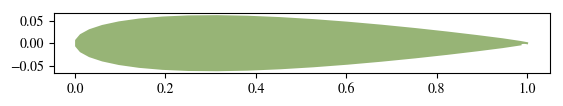

In [65]:
p = Polygon(vert)
plot(p)

In [66]:
vert

39-element Array{Complex{Float64},1}:
      1.0+0.0im       
 0.985383+0.00264447im
  0.94539+0.00862246im
  0.88901+0.0157682im 
  0.82351+0.0235102im 
 0.752405+0.0312625im 
 0.678104+0.0386332im 
 0.602468+0.0453108im 
 0.527021+0.0510149im 
 0.453065+0.0554798im 
  0.38174+0.0584593im 
 0.314069+0.0597429im 
  0.25098+0.0591768im 
         ⋮            
  0.25098-0.0591768im 
 0.314069-0.0597429im 
  0.38174-0.0584593im 
 0.453065-0.0554798im 
 0.527021-0.0510149im 
 0.602468-0.0453108im 
 0.678104-0.0386332im 
 0.752405-0.0312625im 
  0.82351-0.0235102im 
  0.88901-0.0157682im 
  0.94539-0.00862246im
 0.985383-0.00264447im